# Topic modelling farmer queries
This notebook represents efforts to model the queries made by ~10m farmers to the Kisan Call Centre over 7+ years of operation (2012-2019). This is made necessary due to the variable quality of labels assigned by the human call agents (large state to state variation in how coherent a topic is).

This is acheived in two stages:
- Correcting crop tags through simple regex
- Correcting query topics through word2vec and ANN modeling

The outcome of this work is better query tagging, this effects two downstream DS products:
- P^3 engine - better (or at least more uniform) tagging should improve predictive model performance
- Hot topic - better insights as an API

This notebook is fairly short and focused. Alternative approaches to this problem can be found in the Legacy folder.

In [1]:
import psycopg2

import pandas as pd
import numpy as np
import seaborn as sns

import os
import matplotlib.pyplot as plt
import gc
import warnings
import sys

sns.set()

pd.set_option('max_colwidth', 800)

In [2]:
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, axi=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    im = axi.imshow(cm, interpolation='nearest', cmap=cmap)
    axi.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    axi.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    """   
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axi.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();"""
    return axi

In [3]:
import json 
import pickle


def dump_keras(m,h, mod_path):
    m.save(mod_path+str(".model"))
    history_dict = h.history
    with open(mod_path, 'wb') as file_pi:
        pickle.dump(history_dict, file_pi)


def load_keras(mod_path):
    model = load_model(mod_path+str(".model"))
    with open(mod_path+str(".history"),'r') as inp:
        history = json.load(inp)
    return model, history


def check_model(path):
    try:
        m, h = load_keras(path)
        return m, h
    except:
        return False, False

### Fetching and exploring the data

In [4]:
# connect to SQL database to retrieve farmpulse data
try:
    connection = psycopg2.connect(user="postgres",
                                  host="localhost",
                                  port="5432",
                                  database="farmpulse")

    cursor = connection.cursor()

except (Exception, psycopg2.Error) as error :
    print("Error while connecting to PostgreSQL", error)

In [5]:
postgreSQL_select_Query = "select * from call_centre.india_prepped"

cursor.execute(postgreSQL_select_Query)
records = cursor.fetchall()

In [6]:
num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]
field_names

['index',
 'crop',
 'created_on',
 'latitude',
 'longitude',
 'query_type',
 'query_text_raw',
 'kcc_answer_raw',
 'state_name',
 'district_name',
 'crop_full',
 'normq']

We can now examine the raw data, note the following variables:

- crop: short version of the crop name
- created_on: Call centre log time
- latitude/longitude: Geotags sourced from Google API
- query_type: the original categorization tag given by the call centre worker
- query_text_raw, kcc_answer_raw: the raw question and answer as recorded by the call centre worker
- state_name, district_name: administrative location
- crop_full: the full name of the crop
- normq: processed questions, the steps are carried out in ETL.py and were as follows:
  - Stop word removed
  - Lemmatization
  - https and punctuation removed
  - Hindi dropped (~15% of data)

In [7]:
df = pd.DataFrame(records, columns=field_names)
df.head(5)

,index,crop,created_on,latitude,longitude,query_type,query_text_raw,kcc_answer_raw,state_name,district_name,crop_full,normq
0,9538542,cotton,2018-11-05 16:38:19,17.33,80.44,market information,cotton sucking pest management;,recommended to spray imidacloprid 60 ml 150 litres of water acre,telangana,khammam,cotton (kapas),"['suck', 'pest', 'manag']"
1,9538544,cotton,2018-11-05 16:39:29,17.33,80.44,market information,cotton nutrient management;,recommended to spray 13;0;45 potassium nitrate 5 grams1 liter of water,telangana,khammam,cotton (kapas),"['nutrient', 'manag']"
2,9538547,paddy,2018-11-05 16:45:16,18.25,78.44,market information,paddy blast management,recommended to sprat hexaconazolezineb 500 grams 200 litres of water acre,telangana,nizamabad,paddy (dhan),"['paddi', 'blast', 'manag']"
3,9538548,groundnut,2018-11-05 16:48:42,19.02,78.47,market information,tobacco caterpiller in ground nut management,recommended to spray chlorpyrifos 500 ml200 litres of water acre,telangana,adilabad,groundnut (pea nut/mung phalli),"['tobacco', 'caterpil', 'ground', 'nut', 'manag']"
4,9538550,chillies,2018-11-05 16:51:51,18.07,80.83,market information,chili white fly management,recommended to spray imidacloprid 60 ml 150 litres of water acre,telangana,khammam,chillies,"['chili', 'white', 'fli', 'manag']"


I've reduced the dataset to only the most popular crops. This reduces the SoW and ensure we have enough data points to build generalisable models. The crops selected are:

In [8]:
print("total dims",df.shape)
original_cropcount = df.crop.value_counts()
print(original_cropcount)

total dims (3822180, 12)
paddy        816846
wheat        655422
cotton       499535
chillies     239008
onion        231355
brinjal      213491
sugarcane    199870
bengal       191470
tomato       186431
groundnut    180435
soybean      167551
potato       134627
maize        106139
Name: crop, dtype: int64


A lot of queries, once the stop words are stripped out, are very short. The below demonstrates the number of words in each normalised string:

In [9]:
lens = pd.Series([len(i) for i in df.normq])
(lens.value_counts()/lens.value_counts().sum()).head().round(2)

29    0.07
18    0.06
27    0.05
19    0.05
26    0.04
dtype: float64

We can see the majority of queries have fewer than 3 words! This creates issues for many topic models due to the sparseness of BoW models.

### Data improvement
We can now turn to the main function of this notebook; to improve the data quality. We will do this in two steps:
- Correction of crop tags
- Correction of topic tags

### Correcting crop tags
Some crops appear to be tagged incorrectly for example; crop A is mentioned in the raw query but a different crop is tagged. Let's see how many of these mismatches there are, using cotton as an example:

In [10]:
def animate_data(dfin):
    """re-animate df for use"""
    if not isinstance(dfin.normq[0], list):
        dfin['normq'] = [eval(i) for i in dfin.normq]
    dfin['Qstr'] = [" ".join(i) for i in dfin.normq]
    dfin['query_text_raw'] = dfin.query_text_raw.str.lower()
    # dfin = dfin.drop('index')

    return dfin

def correct_crops(dfin):
    """correct crop categories based on finding the crop name in the query string"""
    for cropname in dfin.crop.value_counts().index[0:10]:
        dfin[cropname] = dfin.query_text_raw.str.contains(cropname) # create bool
        before = dfin[(dfin.crop!=cropname) & (dfin[cropname].values==True)].shape[0] #N mismatches
        dfin.loc[dfin[(dfin.crop!=cropname) & (dfin[cropname].values==True)].index, 'crop'] = cropname
        dfin.drop(cropname, axis=1, inplace=True)
        print("corrected {} for {}".format(before, cropname))

    return(dfin)

In [11]:
df = animate_data(df)

In [12]:
# demo that some names are mismatched
df['cotton'] = df.query_text_raw.str.contains("cotton")
print(df.cotton.sum(),"cotton mentioned in query ")
print(df[df.crop=='cotton'].shape[0], "cotton tagged as *crop*")
print(df[(df.crop!='cotton') & (df.cotton==True)].shape[0] , 'cotton mismatches (cotton in string but other crop tagged)')

343211 cotton mentioned in query 
499535 cotton tagged as *crop*
7517 cotton mismatches (cotton in string but other crop tagged)


The above output demonstrates that there are approx. 7500 entries (~1.5%) that explicitly mention cotton, but are marked as other crops. I've attached a sample of these below:

In [13]:
df['cotton'] = df.query_text_raw.str.contains("cotton")
# take not of red cotton bug causing wrong classification
df[(df.crop!='cotton') & (df.cotton==True)][['query_text_raw','crop', 'index']].head() 

,query_text_raw,crop,index
65,cotton sucking pest management,maize,9538667
476,cotton leaf eating caterpillar,paddy,9539356
477,cotton leaf eating caterpillar,paddy,9539357
734,stem borer management in cotton,maize,9539746
942,nutrient management in cotton,chillies,9540062


Let's now correct these for all crops:

In [14]:
# fix all names
df = correct_crops(df)

corrected 5917 for paddy
corrected 15546 for wheat
corrected 7933 for cotton
corrected 605 for chillies
corrected 3322 for onion
corrected 1715 for brinjal
corrected 3106 for sugarcane
corrected 388 for bengal
corrected 3604 for tomato
corrected 1613 for groundnut


We can see how the number of recorded entries has changed by crop:

In [16]:
print(np.sum(np.absolute(df.crop.value_counts() - original_cropcount)), "alterations")
df.crop.value_counts() - original_cropcount

38556 alterations


paddy       -10771
wheat         9372
cotton        5110
chillies     -1790
onion         1768
brinjal       -119
sugarcane     -434
bengal       -1900
tomato        2239
groundnut      789
soybean      -1599
potato       -1665
maize        -1000
Name: crop, dtype: int64

In [17]:
unique_crops = str("_".join(df.crop.unique())) + str("_")
unique_crops

'cotton_paddy_groundnut_chillies_maize_tomato_bengal_wheat_brinjal_onion_sugarcane_potato_soybean_'

### Fixing query types
We can also attempt to re-tag the queries. This is slightly more complex as we want to analyse the content of the call records and assign a category based on that content.

We do have some constraints to account for when deciding our strategy:

- Constraint 1: documents are ultra-short
  - more than half our documents consist of less than 3 words, this will severely hamper traditional statistical approaches (such as LDA) due to sparseness
- Constraint 2: must be humanly intelligible
  - As with most topic models, we want our labels to be humanly intelligible so we can assign the right content for our P^3 solution, this means we will have to enforce topic names at some point.

Given the above constraints, I have decided on a word2vec approach. The plan is to generate dense vectors describing the dataset, and then use the existing topic tags in a supervised classification task to re-tag all the queries. This approach assumes the majority of topic tags are correct. We can assess this assumption by looking at the agreement between the "predicted" tags and the original tags, as well as PCA analysis of the original and new tags (we'd expect to see tighter clustering with the new tags).

Note that the short doc length may also negatively impact the W2V model (through reduced context windows) but we would still expect this to be better than an LDA model, keyword tagging, or biterm topic modelling due to the ability of W2V to easily understand synonyms, spelling errors, and word relations. Additionally, another advantage to this approach is we can use existing topic labels, rather than having to derive new ones by hand.

Overall, we expect this approach to yield two benefits:
- Correcting out-right error by majority vote
- Making topic tagging more uniform across states/call centre workers (note that even if this is independent of the above we would still expect improvements in our downstream modelling)

Let's now turn to preparing the datset.

In [18]:
crop_selected = 'cotton'

In [19]:
def prepare_texts(dataf, crop_sel=None):
    """Prepare texts, tags (classes) and dataframe from raw data"""
    if crop_sel:
        dataf = dataf.loc[df.crop==crop_sel,:]
    dataf.dropna(inplace=True)
    dataf = dataf[dataf.query_type!='nan']

    # take only the top 15 as categories. Set everything else to Misc (this affects only a small number of queries)
    top10 = dataf.query_type.value_counts().index[0:15]
    ind = dataf[~dataf.query_type.isin(top10)].index
    dataf.loc[ind, 'query_type'] = "Misc"

    dataf.reset_index(inplace=True, drop=True)
    texts = dataf.normq #list(filter(lambda x: x != "cotton",d.normQ)) #filter out crop name
    tags = dataf.query_type
    return texts, tags, dataf[['crop','created_on','latitude','longitude','query_type','state_name','district_name','query_text_raw','kcc_answer_raw']]

In [26]:
# texts, tags, d = prepare_texts(df, crop_sel=crop_selected)
texts, tags, d = prepare_texts(df)

#texts, tags, d = prepare_texts(df.drop_duplicates('query_text_raw'), crop_sel=crop_selected)

In [27]:
texts[:5]

0                        [suck, pest, manag]
1                          [nutrient, manag]
2                      [paddi, blast, manag]
3    [tobacco, caterpil, ground, nut, manag]
4                 [chili, white, fli, manag]
Name: normq, dtype: object

In [28]:
tags.value_counts()

plant protection                    1834408
fertilizer use and availability      367222
cultural practices                   232958
nutrient management                  218567
varieties                            207411
market information                   180930
seeds                                133138
weed management                      128628
Misc                                  98789
field preparation                     97959
weather                               91496
biopesticides and biofertilizers      78510
seeds and planting material           54371
agriculture mechanization             42465
government schemes                    34021
water management                      21307
Name: query_type, dtype: int64

In [29]:
print(len(texts), "documents prepared for model")
# print(len(resampled), "subsample documents prepared for model")

3822180 documents prepared for model


In [30]:
from gensim.models import Word2Vec

# vocab attribute no longer exists, use index_to_key instead
word2vec = Word2Vec(texts, min_count=100, workers=4)
vocabulary = word2vec.wv.index_to_key
word_vectors = word2vec.wv

In [31]:
wcount = {}
for item in vocabulary:
    wcount[item] = word_vectors.get_vecattr(item, "count")

wcount = pd.DataFrame({"Word":list(wcount.keys()), "Count": list(wcount.values()), "vec":[word_vectors[i] for i in wcount.keys()]}).sort_values('Count', ascending=False)
vec_samp = [pd.DataFrame(word_vectors[i]) for i in wcount.Word.values]

In [32]:
wcount.drop('vec', axis=1).head(20)

,Word,Count
0,control,995939
1,paddi,599493
2,ask,477732
3,varieti,364887
4,tell,358688
5,fertil,321173
6,manag,292209
7,leaf,240494
8,attack,232752
9,weed,212968


In [33]:
wcount.loc[[23,10]]

,Word,Count,vec
23,growth,102824,"[0.4298359, 0.7241463, 0.13838497, -0.12645912, 0.42603967, -0.54826087, -0.37788746, 3.1321392, 0.8347868, -1.4360194, 1.7296491, 0.42314622, -0.3220494, -0.9779699, 1.9694544, 1.3446034, 0.7694257, -0.0019856826, 1.8750285, 1.0430636, 1.0930922, 0.46596327, -1.32969, -1.7306043, -1.2406592, -0.71946573, 0.83310956, 0.84703416, 0.62885815, 0.9596268, 2.541625, 0.8480363, -2.0000901, -1.6869217, 0.69395566, -1.0846814, 1.8719943, 0.41341448, -0.67964405, -0.32321438, 2.3954446, -0.7208832, 1.8821043, -0.5300761, 0.84398484, -1.4156786, 0.4451317, 0.53871125, -0.6499773, -0.9853702, 0.7508854, 0.091767386, -2.02884, 0.03843158, -2.9738953, -1.0457236, 2.3956997, 1.0979003, -0.23905689, -0.43935922, 0.97462255, -0.15521571, 1.1877544, 0.19473097, -0.9701157, 0.37452966, 0.926919, -1.2068..."
10,chilli,169314,"[-0.16878276, 0.25921914, 0.9478629, -0.57738405, 1.5816318, -0.75547403, -1.4615209, -0.22670105, 0.38794473, 1.6964804, 0.84658307, -0.060453422, 0.51978266, -1.1077123, -0.5808276, -0.46525687, -0.72601163, 1.3245552, 0.21275075, -1.8715816, 1.8286529, -0.21859972, 0.6280031, 0.49435276, -0.31338316, 0.66188323, 1.1497366, -0.35382566, -0.02951185, 0.8989182, -0.58876175, 0.712225, -0.042867146, 0.5272133, -0.9803832, -0.42966232, -0.90077573, 0.7920913, 0.15884553, -1.1087823, 0.5580403, 0.16221878, 1.86927, 1.306319, -0.57849383, -0.6884561, -1.451985, 0.5044533, -0.15835762, 0.20973542, -1.8705429, -0.82215196, 0.30528626, -1.2216136, 1.6220953, 0.1212989, 0.36672723, -0.70266247, 2.058821, 0.36811256, 0.818418, -0.47310746, -1.2248214, 1.3556174, -0.3048275, 0.3911318, -0.974662..."


W2V is an amazingly versatile approach, for example, we can ask the model which of the following words doesn't match:
- Market
- rate
- attack
- price

And it will correctly return attack

In [27]:
print("Odd one out:", word_vectors.doesnt_match("market rate attack price".split()))

Odd one out: attack


In [28]:
samps = pd.DataFrame({"Word":vocabulary, "Vector":word_vectors})

In [29]:
samps.head()

,Word,Vector
0,control,"[[1.0414433, 0.16857888, 0.4110859, 1.6709977, 1.0793601, -0.4910428, -0.46769324, -1.5342121, -0.6829507, -2.1581702, -0.11512313, 1.0191578, 0.01039031, 1.7966899, 2.8742592, -0.980708, 0.06452734, -0.08432116, -0.91196346, -0.41514766, -0.50079906, 0.1452769, -0.5198694, -0.07110589, 0.7152698, -0.8587738, 0.5310253, 0.489615, 0.69611925, -1.5295268, -0.8972003, 0.27253518, -2.157055, 0.06767428, 0.09195128, 0.18596509, -0.4420577, 0.1594031, -0.10293911, -0.09916652, 1.5416328, 2.3811314, 0.463453, 1.1017534, -1.5985322, -0.08268442, 0.93550116, -1.2764298, 1.4077892, -0.100334786, 0.93373525, -0.9460587, -1.8060215, 0.06369891, 0.41927615, 1.912347, 0.09465565, 1.0145806, 2.1179388, 1.95917, -0.7826935, -0.69372463, 0.12923108, -1.3978394, -0.42235622, -0.5945995, 0.5224019, 1.016..."
1,paddi,"[[1.0414433, 0.16857888, 0.4110859, 1.6709977, 1.0793601, -0.4910428, -0.46769324, -1.5342121, -0.6829507, -2.1581702, -0.11512313, 1.0191578, 0.01039031, 1.7966899, 2.8742592, -0.980708, 0.06452734, -0.08432116, -0.91196346, -0.41514766, -0.50079906, 0.1452769, -0.5198694, -0.07110589, 0.7152698, -0.8587738, 0.5310253, 0.489615, 0.69611925, -1.5295268, -0.8972003, 0.27253518, -2.157055, 0.06767428, 0.09195128, 0.18596509, -0.4420577, 0.1594031, -0.10293911, -0.09916652, 1.5416328, 2.3811314, 0.463453, 1.1017534, -1.5985322, -0.08268442, 0.93550116, -1.2764298, 1.4077892, -0.100334786, 0.93373525, -0.9460587, -1.8060215, 0.06369891, 0.41927615, 1.912347, 0.09465565, 1.0145806, 2.1179388, 1.95917, -0.7826935, -0.69372463, 0.12923108, -1.3978394, -0.42235622, -0.5945995, 0.5224019, 1.016..."
2,ask,"[[1.0414433, 0.16857888, 0.4110859, 1.6709977, 1.0793601, -0.4910428, -0.46769324, -1.5342121, -0.6829507, -2.1581702, -0.11512313, 1.0191578, 0.01039031, 1.7966899, 2.8742592, -0.980708, 0.06452734, -0.08432116, -0.91196346, -0.41514766, -0.50079906, 0.1452769, -0.5198694, -0.07110589, 0.7152698, -0.8587738, 0.5310253, 0.489615, 0.69611925, -1.5295268, -0.8972003, 0.27253518, -2.157055, 0.06767428, 0.09195128, 0.18596509, -0.4420577, 0.1594031, -0.10293911, -0.09916652, 1.5416328, 2.3811314, 0.463453, 1.1017534, -1.5985322, -0.08268442, 0.93550116, -1.2764298, 1.4077892, -0.100334786, 0.93373525, -0.9460587, -1.8060215, 0.06369891, 0.41927615, 1.912347, 0.09465565, 1.0145806, 2.1179388, 1.95917, -0.7826935, -0.69372463, 0.12923108, -1.3978394, -0.42235622, -0.5945995, 0.5224019, 1.016..."
3,varieti,"[[1.0414433, 0.16857888, 0.4110859, 1.6709977, 1.0793601, -0.4910428, -0.46769324, -1.5342121, -0.6829507, -2.1581702, -0.11512313, 1.0191578, 0.01039031, 1.7966899, 2.8742592, -0.980708, 0.06452734, -0.08432116, -0.91196346, -0.41514766, -0.50079906, 0.1452769, -0.5198694, -0.07110589, 0.7152698, -0.8587738, 0.5310253, 0.489615, 0.69611925, -1.5295268, -0.8972003, 0.27253518, -2.157055, 0.06767428, 0.09195128, 0.18596509, -0.4420577, 0.1594031, -0.10293911, -0.09916652, 1.5416328, 2.3811314, 0.463453, 1.1017534, -1.5985322, -0.08268442, 0.93550116, -1.2764298, 1.4077892, -0.100334786, 0.93373525, -0.9460587, -1.8060215, 0.06369891, 0.41927615, 1.912347, 0.09465565, 1.0145806, 2.1179388, 1.95917, -0.7826935, -0.69372463, 0.12923108, -1.3978394, -0.42235622, -0.5945995, 0.5224019, 1.016..."
4,tell,"[[1.0414433, 0.16857888, 0.4110859, 1.6709977, 1.0793601, -0.4910428, -0.46769324, -1.5342121, -0.6829507, -2.1581702, -0.11512313, 1.0191578, 0.01039031, 1.7966899, 2.8742592, -0.980708, 0.06452734, -0.08432116, -0.91196346, -0.41514766, -0.50079906, 0.1452769, -0.5198694, -0.07110589, 0.7152698, -0.8587738, 0.5310253, 0.489615, 0.69611925, -1.5295268, -0.8972003, 0.27253518, -2.157055, 0.06767428, 0.09195128, 0.18596509, -0.4420577, 0.1594031, -0.10293911, -0.09916652, 1.5416328, 2.3811314, 0.463453, 1.1017534, -1.5985322, -0.08268442, 0.93550116, -1.2764298, 1.4077892, -0.100334786, 0.93373525, -0.9460587, -1.8060215, 0.06369891, 0.41927615, 1.912347, 0.09465565, 1.0145806, 2.1179388, 1.95917, -0.7826935, -0.69372463, 0.1292

Likewise we can see which words have the highest similarity to others (below), and we can see this yields sensible results:

In [30]:
keys = ['market','pest','nutrient','fertil','control','varieti','weed']
for i in keys:
    print(i, end=" - ")
    for a, b in word_vectors.similar_by_word(i, topn=6):
        print(a, round(b,3), end=", ")
    print("\n")

market - msp 0.79, markat 0.772, marketr 0.722, mkt 0.696, markeet 0.661, sagar 0.656, 

pest - insect 0.631, past 0.624, thrip 0.6, whitefli 0.596, aphid 0.562, fli 0.552, 

nutrient - nutrent 0.762, nutreint 0.673, micronutri 0.599, nutriant 0.539, fertliz 0.484, fertila 0.482, 

fertil - fertilis 0.864, feril 0.805, fertliz 0.798, fertilz 0.781, fetil 0.758, frtiliz 0.744, 

control - contro 0.694, conrol 0.674, contrl 0.666, contol 0.657, cntrol 0.652, problem 0.643, 

varieti - variti 0.835, varieit 0.809, veriti 0.779, verieti 0.77, varietei 0.757, varit 0.738, 

weed - wed 0.807, weeed 0.662, rat 0.562, termit 0.531, nutreint 0.527, gullidanda 0.48, 



- Market matches with:
  - District names (e.g. Villupuram, etc)
- pest matches with:
  - pest related words, such as "larva", "whitefli"
  - Also matches to typos (such as peat)
- nutrient matches with:
  - micronutrient related words micro, mn, fertilit

### Supervised learning with W2V
Let's create the vector representation of each entry and use this to build a supervised model:

In [31]:
def get_w2v_features(w2v_model, text_sentence):
    """generate vector from texts"""
    index2word_set = set(w2v_model.wv.index_to_key)  # words known to model
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")

    # counter
    nwords = 0
    # w2v summer
    for word in text_sentence:
        if word in index2word_set:
            featureVec = np.add(featureVec, w2v_model.wv[word])
            nwords += 1.

    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wv_features = pd.DataFrame(list(map(lambda sen_group:
                                          get_w2v_features(word2vec, sen_group),
                                          texts)))

wv_features.columns = ["f{}".format(n) for n in range(len(wv_features.columns))]

## Logistic Reg

In [ ]:
from joblib import dump, load
from sklearn.metrics import f1_score


def correct_tags_logr(target_var, predictor_vars, frac=0.7, overwrite=True):
    """fit a multi-class  logistic regression and return predicted labels
    params:
        target_var: y
        predictor_vars = X
        frac = . train test split
        overwrite = whether to overwrite existing, True will retrain and overwrite,
        False will try to load, and any other value will retrain but NOT overwrite.
    """
    from sklearn.linear_model import LogisticRegression

    # picks a fraction of input data randomly as training sample
    target_train = target_var.sample(frac=frac).index
    # indexes after excluding training indexes
    target_test = target_var.drop(target_train).index
    path = './data/logr.joblib'

    if os.path.exists(path) and overwrite is False:
        clf = load(path)
        print("reloaded from ", path)
    else:
        print("training new model...")
        clf = LogisticRegression(random_state=11, max_iter=250, solver='lbfgs',
                                 multi_class='ovr', n_jobs=4, penalty='l2',
                                 class_weight="balanced", C=0.1)
        clf.fit(predictor_vars.loc[target_train], target_var.loc[target_train])
        if overwrite is True:
            dump(clf, path)

    f = f1_score(clf.predict(predictor_vars.loc[target_test]),
                 target_var.loc[target_test], average='macro')
    fw = f1_score(clf.predict(predictor_vars.loc[target_test]),
                  target_var.loc[target_test], average='weighted')
    a = clf.score(predictor_vars.loc[target_test],
                  target_var.loc[target_test])*100

    print(round(f, 2), "F1 Macro")
    print(round(fw, 2), "F1 Weighted")
    print(round(a), "% match")

    predicted_labels = clf.predict(predictor_vars)
    # print(predictor_vars.loc[target_test].head(5))
    print(target_train)
    print(target_test)
    print(target_var.loc[target_test][:5])
    print(clf.predict(predictor_vars.loc[target_test][:5]))

    return predicted_labels

We will first run our model on a shuffled dataset, to demonstrate the baseline error expected:

In [ ]:
random_guess = correct_tags_logr(target_var=tags,
                                 # sample with frac 1.0 just reshuffles index,
                                 # wv_features is a df
                                 predictor_vars=wv_features.sample(frac=1.0).
                                 reset_index(drop=True), frac=0.1)
random_guess

And now on the real dataset:

In [ ]:
# real use
newlabel_logr = correct_tags_logr(target_var=tags, predictor_vars=wv_features,
                                  frac=0.33, overwrite=False)
newlabel_logr

If our central assumption is true (the majority of tags are correct), then trained model should be able to predict the correct class, and we would expect to see reasonable (but not perfect) agreement between the original labels and new labels.

The word2vec model and the original labels have ~70% agreement.

In [ ]:
gc.collect()

### ANN
The logistic model seems to be struggling, it's also quite slow. Let's run an ANN with keras to see if we can improve performance.

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

import os
import tempfile

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [34]:
from tensorflow.keras import metrics

In [35]:
def make_metrics():

    M = [
        keras.metrics.CategoricalAccuracy(name='accuracy'),
        keras.metrics.TopKCategoricalAccuracy(name='kacc',k=5),
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
        ]
    return M

METRICS = make_metrics()

In [36]:
num_class = len(tags.value_counts())
num_class

16

In [37]:
from tensorflow.keras.utils import to_categorical

tags_flat = to_categorical(tags.astype('category').cat.codes)
tags_coded = tags.astype('category').cat.codes

train_ind = wv_features.sample(frac=0.8).index
test_ind = wv_features.drop(train_ind).index

In [38]:
def make_model(metrics=METRICS, output_bias=None):

    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = keras.Sequential([
          keras.layers.Dense(
              32, activation='tanh',
              input_shape=(100,)),
          keras.layers.Dropout(0.15),
          keras.layers.Dense(num_class, activation='sigmoid',
                             bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=metrics)

    return model

In [39]:
EPOCHS = 35
BATCH_SIZE = 4096

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_kacc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [40]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                3232      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
Total params: 3,760
Trainable params: 3,760
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.predict(wv_features[:1])

array([[0.33139515, 0.40424412, 0.54911864, 0.6271135 , 0.7608962 ,
        0.7232709 , 0.63492906, 0.12738198, 0.50619   , 0.36342832,
        0.72555435, 0.38301197, 0.26405606, 0.18511552, 0.5389756 ,
        0.32250994]], dtype=float32)

In [42]:
pd.concat([tags, tags_coded], axis=1).drop_duplicates()

,query_type,0
0,plant protection,9
1,fertilizer use and availability,4
2,varieties,12
3,nutrient management,8
10,weed management,15
14,weather,14
15,market information,7
22,cultural practices,3
40,seeds,10
41,field preparation,5


In [43]:
tags[0], tags_coded[0], tags_flat[0]

('plant protection',
 9,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32))

In [44]:
results = model.evaluate(wv_features[0:100000], tags_flat[0:100000],
                         batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 2.9470


In [45]:
label_codes = pd.concat([tags, tags_coded],axis=1).drop_duplicates()
label_codes.columns = ['label','code']
label_codes.head(3)

,label,code
0,plant protection,9
1,fertilizer use and availability,4
2,varieties,12


In [46]:
initial_bias = (tags.value_counts()/tags.value_counts().mean())
initial_bias = pd.DataFrame(initial_bias)
initial_bias.columns=['bias']

In [47]:
initial_bias = initial_bias.merge(label_codes, left_index=True, right_on='label').sort_values('code')

In [48]:
initial_bias['bias'] = np.log(initial_bias.bias.values)

In [49]:
initial_bias

,bias,label,code
330,-0.883001,Misc,0
290,-1.727307,agriculture mechanization,1
112,-1.112761,biopesticides and biofertilizers,2
22,-0.025129,cultural practices,3
1,0.429979,fertilizer use and availability,4
41,-0.891438,field preparation,5
1438,-1.949010,government schemes,6
15,-0.277877,market information,7
3,-0.088895,nutrient management,8
0,2.038490,plant protection,9


In [50]:
model = make_model(output_bias=initial_bias.bias.values)
model.predict(wv_features[0:1])

array([[0.4657096 , 0.17935857, 0.33511135, 0.5260798 , 0.4416794 ,
        0.36559266, 0.05318171, 0.5805214 , 0.48834813, 0.84376705,
        0.21966794, 0.13586503, 0.69226587, 0.10713267, 0.15373516,
        0.4590141 ]], dtype=float32)

With this initialization the initial loss per class should be approximately:

$-p_0 log(p_0) - (1-p_0)log(1-p_0) = 3.1 $

In [51]:
results = model.evaluate(wv_features, tags_flat, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 2.2230


We can see the initial loss is now substantially lower.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

Let's confirm:

In [52]:
initial_weights = './data/initial_weights'
model.save_weights(initial_weights)

In [53]:
xtrain = wv_features.loc[train_ind]
ytrain = tags_flat[train_ind]

xval = wv_features.loc[test_ind]
yval = tags_flat[test_ind]

In [54]:
modela = make_model()
#modela.load_weights(initial_weights)
modela.layers[-1].bias.assign(np.ones(16)) # zero bias
zero_bias_history = modela.fit(
    xtrain,
    ytrain,
    batch_size=256,
    epochs=25,
    validation_data=(xval, yval), 
    verbose=0)

In [55]:
modelb = make_model()
modelb.load_weights(initial_weights)
careful_bias_history = modelb.fit(
    xtrain,
    ytrain,
    batch_size=256,
    epochs=25,
    validation_data=(xval, yval), 
    verbose=0)

In [56]:
def plot_loss(history, label, n ,var='loss'):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history[var],
               color=n, label='Train '+label)
    plt.semilogy(history.epoch,  history.history["val_{}".format(var)],
          color=n, label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel(var)
    plt.xlim(0,5)

    plt.legend()

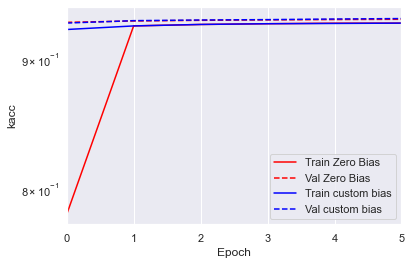

In [57]:
plot_loss(zero_bias_history, "Zero Bias", 'Red', 'kacc')
plot_loss(careful_bias_history, "custom bias", 'Blue', 'kacc')

### Unopt model

In [58]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    xtrain,
    ytrain,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(xval, yval),
    verbose=0)

In [59]:
def plot_metrics(history):
    metrics =  ['loss', 'accuracy', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color='Blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='Red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()
    plt.tight_layout()

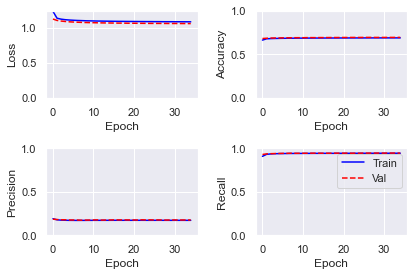

In [60]:
plot_metrics(baseline_history)

In [61]:
# pred = model.predict_classes(xval)

# use np.argmax instead of predict_classes (deprecated)
pred = np.argmax(model.predict(xval), axis=-1)

In [62]:
label_codes = pd.concat([tags, tags_coded],axis=1).drop_duplicates()
label_codes.columns= ["label","code"]
label_codes = label_codes.sort_values('code').reset_index(drop=True)

Normalized confusion matrix


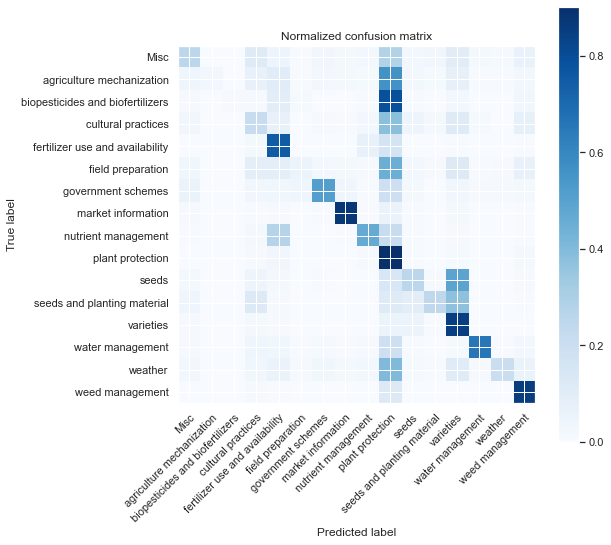

In [63]:
plt.figure(figsize=(8,8))
ax= plt.subplot(111)
ax = plot_confusion_matrix(tags_coded[test_ind], pred, classes=label_codes.label, normalize=True,
                      title='Normalized confusion matrix', axi=ax);

Normalized confusion matrix


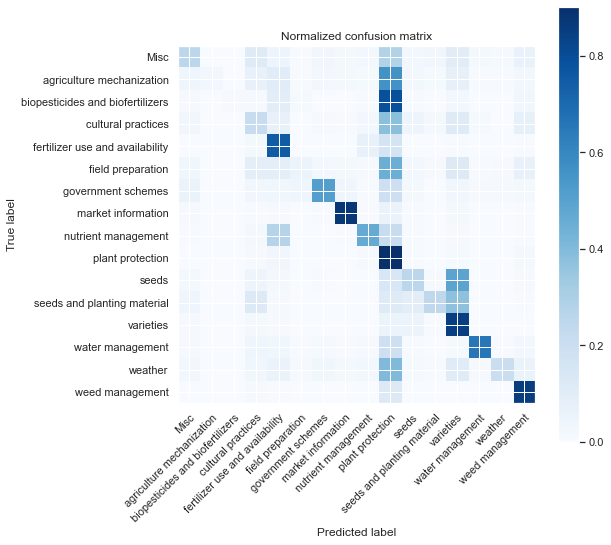

In [64]:
plt.figure(figsize=(8,8))
ax= plt.subplot(111)
ax = plot_confusion_matrix(tags_coded[test_ind], pred, classes=label_codes.label, normalize=True,
                      title='Normalized confusion matrix', axi=ax);

In [67]:
f1_score(y_true=tags_coded, y_pred=np.argmax(model.predict(wv_features), axis=-1), average='weighted')

0.6573311518983914

In [68]:
dump_keras(model,baseline_history, "./models/baseline")

INFO:tensorflow:Assets written to: ./models/baseline.model/assets


### With class weights

In [69]:
import numpy as np
import math


def create_class_weight(labels,mu=0.15):
    total = labels.sum()
    keys = labels.keys()
    cw = dict()

    # make a cap
    mean_score = np.round(np.mean([math.log(mu*total/float(labels[i])) for i in keys]), 2)

    for key in keys:
        score = math.log(mu*total/float(labels[key] ))
        cw[key] = round(score, 2) if score < mean_score else 1.0 #round(score,2)  if score < mean_score else mean_score

    return cw

In [70]:
# gentle reweighting
weights = create_class_weight(tags_coded.value_counts(), 1)
weights

{9: 0.73,
 4: 2.34,
 3: 2.8,
 8: 2.86,
 12: 2.91,
 7: 3.05,
 10: 3.36,
 15: 3.39,
 0: 1.0,
 5: 1.0,
 14: 1.0,
 2: 1.0,
 11: 1.0,
 1: 1.0,
 6: 1.0,
 13: 1.0}

In [71]:
weight_array = np.array([weights[i] for i in range(len(weights.keys()))])

In [72]:
try:
    weighted_model, weighted_history = load_keras("./models/weighted_model")
except:
    weighted_model=False

In [73]:
keras.backend.clear_session()

In [74]:
METRICS = make_metrics()

In [75]:
def make_optimal_model(metrics=METRICS, output_bias=None):

    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = keras.Sequential([
          keras.layers.Dense(
              64, activation='sigmoid',
              input_shape=(100,)),
          keras.layers.Dropout(0.3),
          keras.layers.Dense(16, activation='sigmoid'),
          keras.layers.Dense(num_class, activation='sigmoid',
                             bias_initializer=output_bias),
      ])

    model.compile(
        optimizer=keras.optimizers.Nadam(),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=metrics)

    return model

In [76]:
weighted_model = make_optimal_model(METRICS, output_bias=initial_bias.bias.values)
#weighted_model.load_weights(initial_weights)

In [77]:
xtrain.shape, ytrain.shape

((3057744, 100), (3057744, 16))

In [78]:
weighted_history = weighted_model.fit(
    xtrain,
    ytrain,
    batch_size=16,
    epochs=50,
    callbacks = [early_stopping],
    validation_data=(xval, yval),
    class_weight=weights,
    verbose=0)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping


In [79]:
weighted_history

In [80]:
dump_keras(weighted_model, weighted_history, "./models/weighted_model")

INFO:tensorflow:Assets written to: ./models/weighted_model.model/assets


In [81]:
# pred = weighted_model.predict_classes(xval)
pred = np.argmax(model.predict(xval), axis=-1)

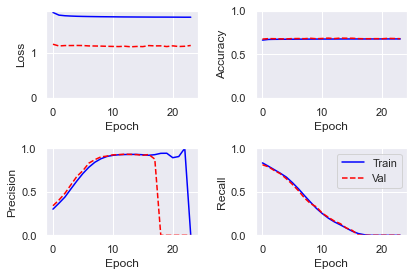

In [82]:
plot_metrics(weighted_history)

Normalized confusion matrix


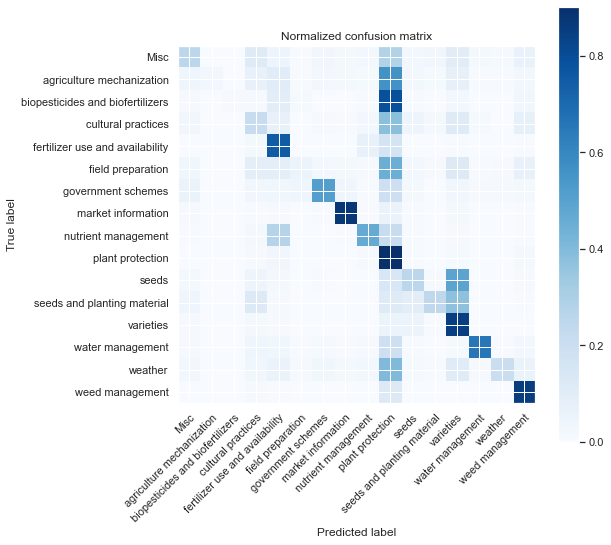

In [83]:
plt.figure(figsize=(8,8))
ax= plt.subplot(111)
ax = plot_confusion_matrix(tags_coded[test_ind], pred, classes=label_codes.label, normalize=True,
                      title='Normalized confusion matrix', axi=ax);

In [84]:
# newlabels = weighted_model.predict_classes(wv_features)
newlabels = np.argmax(model.predict(wv_features), axis=-1)

In [85]:
print("f1w", f1_score(y_true=tags_coded, y_pred=newlabels, average='weighted') )
print("f1w", f1_score(y_true=tags_coded, y_pred=newlabels, average='macro') )

f1w 0.6573311518983914
f1w 0.44024602203764496


In [86]:
weighted_model.weights

[<tf.Variable 'dense/kernel:0' shape=(100, 64) dtype=float32, numpy=
 array([[ 1.496438  , -0.85241   , -1.9266108 , ..., -0.9664553 ,
          2.6661723 , -2.3459303 ],
        [-1.3439145 , -0.553016  ,  1.874511  , ..., -3.7379985 ,
         -1.9652886 , -2.396553  ],
        [ 2.0551524 , -1.2931359 ,  0.86451435, ...,  1.5411515 ,
         -3.3258228 , -1.6729821 ],
        ...,
        [-2.9851944 ,  1.492871  ,  2.4560921 , ...,  0.05893559,
         -0.21625823,  2.3738747 ],
        [ 0.46806398,  0.3836613 , -2.9078493 , ...,  0.72583556,
          0.94433373, -0.74068   ],
        [ 2.7763398 , -1.2972976 ,  3.6057212 , ..., -3.3074596 ,
         -0.66198194, -0.5807714 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(64,) dtype=float32, numpy=
 array([-4.7072144 , -4.341283  , -6.631864  , -5.9401994 , -2.713153  ,
        -1.0464972 , -2.7871175 , -2.183273  , -4.2332063 , -5.703111  ,
        -4.426887  , -5.540199  , -4.0558357 , -6.352446  , -7.7360415 ,
      

In [87]:
label_codes.set_index(label_codes.code, inplace=True)

In [88]:
label_codes.loc[10]

label    seeds
code        10
Name: 10, dtype: object

In [89]:
# newlabel = weighted_model.predict_classes(wv_features)
newlabel = np.argmax(model.predict(wv_features), axis=-1)

In [90]:
newlabel = pd.DataFrame(newlabel, columns=['Labelcode'])

In [91]:
newlabel = label_codes.merge(newlabel, left_index=True, right_on='Labelcode', how='right')

In [92]:
d['newlabel'] = newlabel.label
d['oldlabel'] = tags
# d['query_type']
d['updated'] = (d.newlabel == d.oldlabel) == False

In [93]:
d.head()[['query_text_raw','kcc_answer_raw','newlabel','oldlabel']]

,query_text_raw,kcc_answer_raw,newlabel,oldlabel
0,tell me control of weed of wheat,"2,4d ester 38% ka 500 gm per hactar 500 litar water spray 3035 days par",weed management,plant protection
1,tell me fertilizers in wheat,urea15kgbigh zink sulfet 45 kgbigha,fertilizer use and availability,fertilizer use and availability
2,tell me late variety of wheat ?,"late variety of wheat raj 3765,raj3777,raj3077",varieties,varieties
3,tell me about nutrient mgt.in wheat ?,"fertiliser in wheat sowing time 80 kg dap,70 kg urea and 20 kg zinc sulphate per hectare first irrigation 100 kg urea per hectare",nutrient management,nutrient management
4,tell me thrips in garlick,use carbofuran 3% g 20 kg per ha,plant protection,plant protection


Scoring the "coherence" of topics is quite difficult here, as the data only have one topic per query. So let's instead examine a random subset:

In [94]:
samp = []
for i in d.newlabel.value_counts().head().index:
    samp.append( d.loc[(d.updated==True) & (d.oldlabel==i), ['query_text_raw','kcc_answer_raw', 'newlabel','oldlabel']].sample(5, random_state=4) )
samp = pd.concat(samp)

In [95]:
samp

,query_text_raw,kcc_answer_raw,newlabel,oldlabel
3818742,spray for increasing size of onion bulb,2325;2366;2306;2342;2366; 2330;2366;2306;2327;2354;2366; 2346;2379;2360;2339;2381;2351;2366;2360;2366;2336;2368; 2354;2366;2327;2357;2337;2368;2344;2306;2340;2352; 80 2342;2367;2357;2360;2366;2306;2344;2368; 2325;2381;8205;2354;2379;2352;2350;2375;2325;2381;2357;2366;2335; 2325;2381;8205;2354;2379;2352;2366;2312;2337; 2360;2361;2366; 2350;2367;.2354;2367;.2354;2367;2335;2352; 2346;2366;2339;2381;2351;2366;2340; 2328;2375;2314;2344; 2347;2357;2366;2352;2339;2368; 2342;2381;2351;2366;2357;2368;.,fertilizer use and availability,plant protection
2027115,price of potato,recomended for advice through http:agmarknet.nic.insearchcmmmkt.asp,market information,plant protection
363093,farmer wants to start mandi rate facility on his mobile?,your mandi rate facility registration has been successfully registered at kishan call center.,field preparation,plant protection
908400,fertilizer spray for growth?,19 19 19 60 gm microlla 30 ml 15 liter water,fertilizer use and availability,plant protection
3454750,15. weed problem in barren land,spray glyphosate 2 ml in 1 litre of water,weed management,plant protection
1189484,tell me insect control in wheat,use imidachloprid 17.8% sl 1 liter per ha with irrigation for control of termite,plant protection,fertilizer use and availability
887963,attack of caterpillar?,spray takumi 5 gm 15 liter of water(flubendiamide 20% ww)tata,plant protection,fertilizer use and availability
1150179,tell me nutrient management ?,spray soluble npk 18:18:18 grade 10 gmltr water,nutrient management,fertilizer use and availability
142915,information regardingh how to control fangle disease in cotton ?,information regardingh how to control fangle disease in cotton ?control are:spraystereptocyclien68 gramcoc coper oxi cloried)600800 gram in 150200 leetr water per acer.,plant protection,fertilizer use and availability
69089,farmer want to know information about ferti. schule for groundnut ?,"manure and fertilizer management according to soil test recommendations made on the basis of the quantity of manure and fertilizers must be ensured. groundnut crop welldecomposed manure to 5 tons per hectare of farmland at the rate of preparation time should be in the dust. 20:60:20 kg as fertilizer. is. nitrogen, phosphorous and potashbased fertilizer should use. peanut sulfur in gypsum source of cheap supply of sulfur is therefore of particular importance. 250 kg of gypsum. before sowing volume per hectare rate of use, use long preparation time. 20:60:20 with 5 tons of peanut manure kg. ha nitrogen, phosphorus and potash with 25 kg. ha zinc sulphate used as the basis for using manure to produce 22 percent have been found in farm trials and demonstrations frontline.",plant protection,fertilizer use and availability


In [96]:
del samp, newlabel
del weighted_model, weighted_history
gc.collect()

50641

As another sense-check, we can see how the tags vary over time, we expect tags to cluster together with time:

Text(0.5, 1.0, 'cotton, original labels maharashtra')

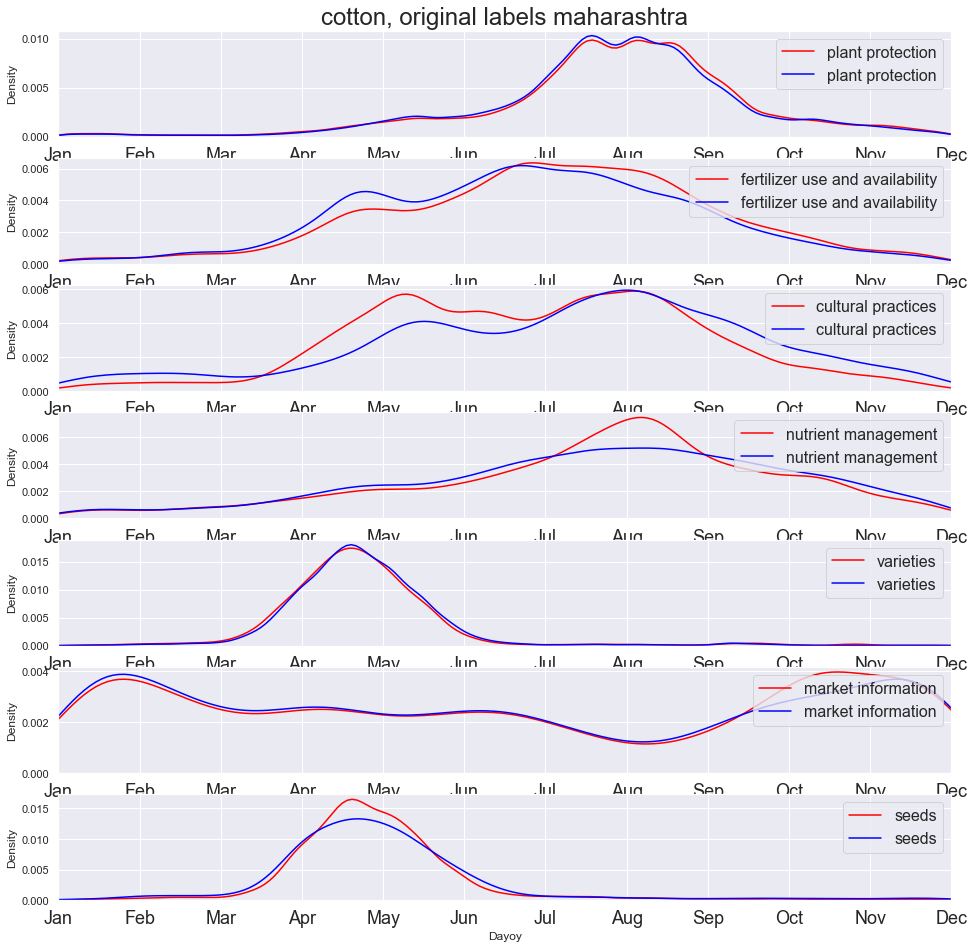

In [97]:
crop = 'cotton'
d['Dayoy'] = pd.to_datetime(d.created_on).dt.dayofyear
target = d['query_type']
issues = target.value_counts().head(7).index.values  #['varieties' ,'weed management','fertilizer use and availability', 'plant protection','market information','biopesticides and biofertilizers','cultural practices']
state = d[d.crop==crop].state_name.value_counts().keys()[0]

fig, axs = plt.subplots(7,1, figsize=(16, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.15)
axs = axs.ravel()

for i in range(len(issues)):
    x = d[(d.crop==crop) & (target==issues[i]) & (d.state_name!=state)].Dayoy #& (df.state_name!=state)
    # sns.distplot(x, hist=False, label = issues[i],ax=axs[i], bins=365, color='red')
    sns.kdeplot(x, label=issues[i], ax=axs[i], color='red')

    x = d[(d.crop==crop) & (d.newlabel==issues[i]) & (d.state_name!=state)].Dayoy #& (df.state_name!=state)
    # sns.distplot(x, hist=False, label = issues[i],ax=axs[i], bins=365, color='blue') #new labels
    sns.kdeplot(x, label=issues[i], ax=axs[i], color='blue') #new labels
    axs[i].set_xlim(0,365)
    axs[i].legend(loc=1, fontsize=16)
    axs[i].set_xticks(np.linspace(0,365,12))
    axs[i].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=18);

axs[0].set_title("{}, original labels {}".format(crop, state), size=24)

From the above it seems like our topics do indeed cluster by time.

Let's look at a 2D PCA plot to visualise topic clustering as another sense-check:

In [98]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(wv_features)

PCA(n_components=3)

In [99]:
print("Total variance explained with 2 components {} %".format(100*round(np.sum(pca.explained_variance_ratio_[0:2]),1)))

Total variance explained with 2 components 40.0 %


In [100]:
pca_vars = pca.transform(wv_features)

Text(0, 0.5, 'PC2')

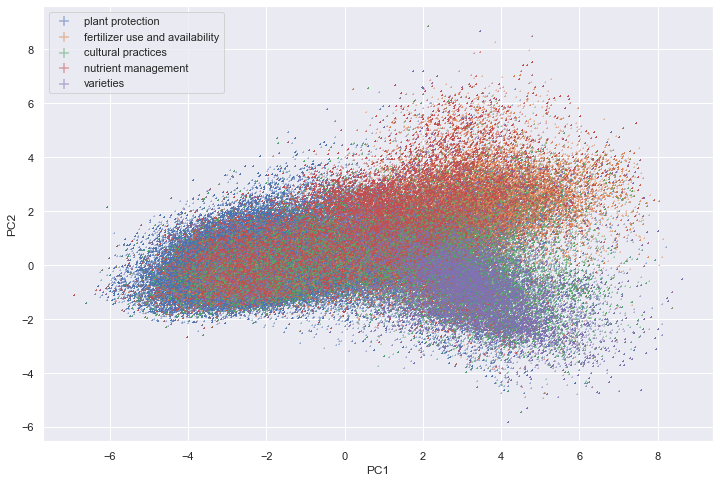

In [101]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
for i in tags.value_counts().index[0:5]:
    ax.scatter(pca_vars[:,0][tags==i], pca_vars[:,1][tags==i], label=i, alpha=0.5, s=1, marker='+')
plt.legend(markerscale=10)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

From the above we can see reasonable seperation in 2 dimensions between the top 5 categories. This is especially clear for market information and fertilizer use.

We can visualise the entries with conflicting tags in the 2 principal components below:

In [102]:
matched = [tags[i]==d.newlabel[i] for i in range(len(tags))]
pca_data = pd.DataFrame({"newlabel":d.newlabel, "oldlabel":tags, "matched":matched, "pca1":pca_vars[:,0], "pca2":pca_vars[:,1]})

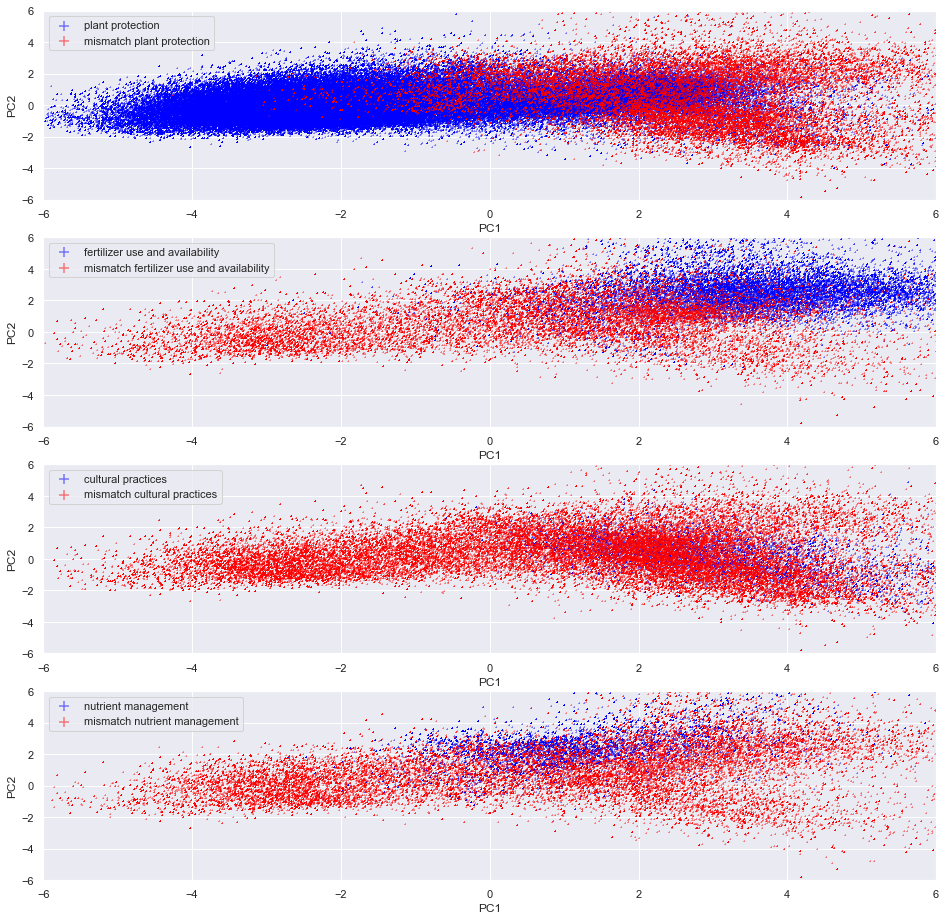

In [103]:
plt.figure(figsize=(16,16))

ax = plt.subplot(411)
sel = tags.value_counts().index[0]
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
plt.legend(markerscale=10)

ax = plt.subplot(412)
sel = tags.value_counts().index[1]
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
plt.legend(markerscale=10)

ax = plt.subplot(413)
sel = tags.value_counts().index[2]
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.legend(markerscale=10)

ax = plt.subplot(414)
sel = tags.value_counts().index[3]
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.legend(markerscale=10)

Notice that there does appear to be a clear clustering of each tag, and the "mismatches" fall outside of that cluster (above).

We can compare this with the new tags, and see how close the mismatches are to their new labels (below):

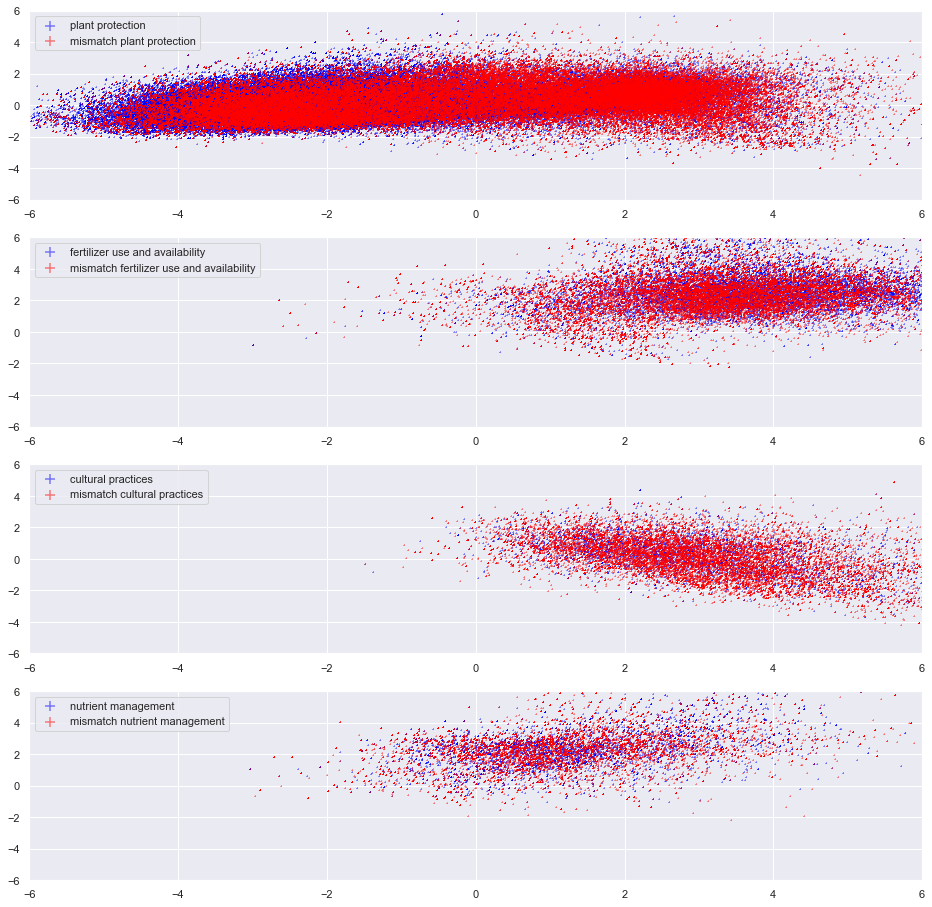

In [104]:
plt.figure(figsize=(16,16))

ax = plt.subplot(411)
sel = tags.value_counts().index[0]
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
plt.legend(markerscale=10)

ax = plt.subplot(412)
sel = tags.value_counts().index[1]
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
plt.legend(markerscale=10)

ax = plt.subplot(413)
sel = tags.value_counts().index[2]
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
plt.legend(markerscale=10)

ax = plt.subplot(414)
sel = tags.value_counts().index[3]
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
plt.legend(markerscale=10)

Side by side this is somewhat clearer:

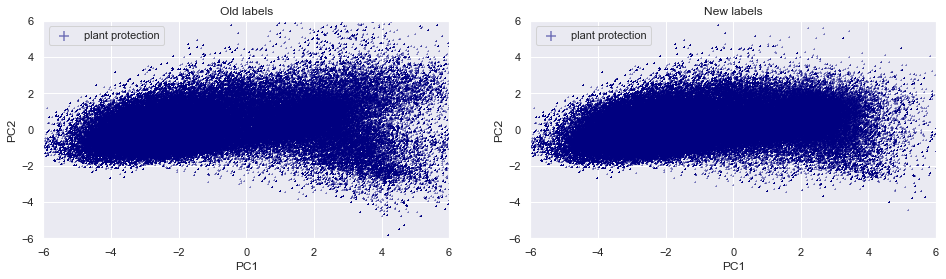

In [105]:
plt.figure(figsize=(16,4))


ax = plt.subplot(121)
sel = tags.value_counts().index[0]
ax.scatter(pca_data[(pca_data.oldlabel==sel)].pca1 , pca_data[(pca_data.oldlabel==sel)  ].pca2, label=sel, alpha=0.5, s=1, marker='+', color='navy')

ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
ax.set_title("Old labels")
plt.legend(markerscale=10)

ax = plt.subplot(122)
sel = tags.value_counts().index[0]
ax.scatter(pca_data[(pca_data.newlabel==sel) ].pca1 , pca_data[(pca_data.newlabel==sel)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='navy')
#ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, alpha=0.5, s=1, marker='+', color='k')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
ax.set_title("New labels")
plt.legend(markerscale=10)

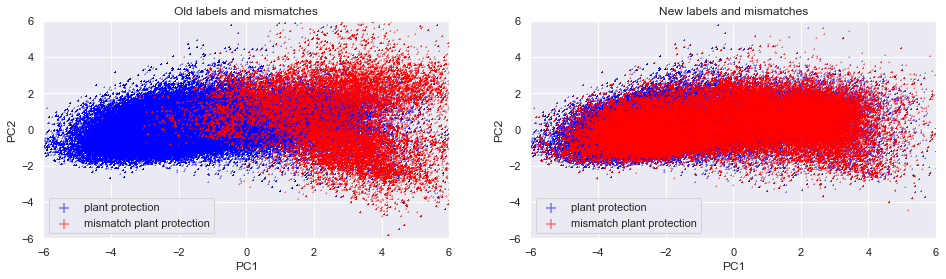

In [106]:
plt.figure(figsize=(16,4))


ax = plt.subplot(121)
sel = tags.value_counts().index[0]
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
ax.set_title("Old labels and mismatches")
plt.legend(markerscale=10)

ax = plt.subplot(122)
sel = tags.value_counts().index[0]
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
ax.set_title("New labels and mismatches")
plt.legend(markerscale=10)

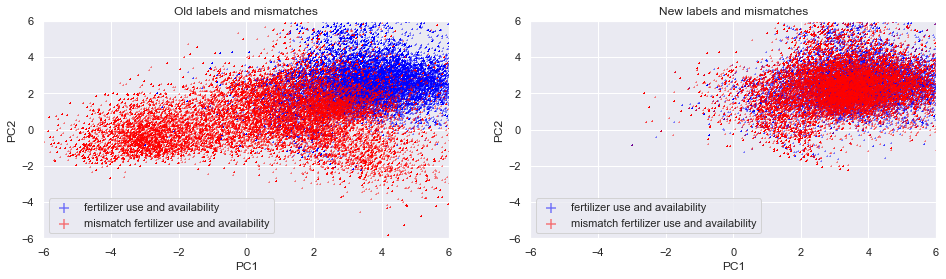

In [107]:
plt.figure(figsize=(16,4))


ax = plt.subplot(121)
sel = tags.value_counts().index[1]
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.oldlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
ax.set_title("Old labels and mismatches")
plt.legend(markerscale=10)

ax = plt.subplot(122)
sel = tags.value_counts().index[1]
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==True)].pca2, label=sel, alpha=0.5, s=1, marker='+', color='blue')
ax.scatter(pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca1 , pca_data[(pca_data.newlabel==sel)  & (pca_data.matched==False)].pca2, label="mismatch {}".format(sel), alpha=0.5, s=1, marker='+', color='red')
ax.set_xlim(-6,6)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_ylim(-6,6)
ax.set_title("New labels and mismatches")
plt.legend(markerscale=10)

In [108]:
def total_spread(data_in, locs, sample=10000000):
    # using det of cov matrix to estimate dispersion of data
    xdata = data_in[locs]#[['pca1','pca2']]
    cov_xdata = np.cov(xdata, rowvar=False) #np.dot(xdata.head(sample).values.T, xdata.head(sample).values)
    #return np.sqrt( np.linalg.det(cov_xdata) )
    return  np.trace(cov_xdata)

In [109]:
oldvals = []
newvals = []

for i in tags.value_counts().index[0:10]:
    oldvals.append( total_spread(wv_features, pca_data.oldlabel==i) )
    newvals.append( total_spread(wv_features, pca_data.newlabel==i) )

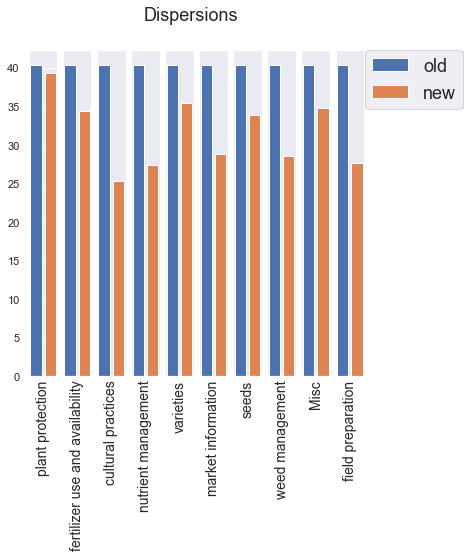

In [110]:
fig, axs = plt.subplots(1,10, figsize=(6, 6), facecolor='w', edgecolor='k')
plt.suptitle("Dispersions", size=18)
for i in range(len(oldvals)):
    axs[i].bar(0, oldvals[i], label="old")
    axs[i].bar(1, newvals[i], label="new")
    axs[i].set_xlabel(tags.value_counts().index[i], size=14, rotation=90)
    axs[i].set_xticks([])
    if i > 0:
        axs[i].set_yticks([])
        
        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=18)

There is much more agreement with the new label distributions vs the old.

Overall this suggests that the new labels are superior to the old.

We also can view the above in 3 dimensions with the interactive plot below (output as a seperate html file to reduce the size of this notebook).

In [111]:
x = pd.DataFrame(pca_vars)
x.columns = ['c1','c2','c3']
x['tags'] = tags
x['size'] = 0.01

import plotly.express as px

fig = px.scatter_3d(x[x.tags.isin(list(tags.value_counts().index[0:5]))].sample(n=1000), x='c1', y='c2', z='c3',
              color='tags', opacity=0.5, size='size' )
# fig.show()
fig.write_html('3d_figure.html', auto_open=True)
# plt.plot(fig)

### Summary
We have built a simple topic prediction model based on word2vec features and a logistic regression model. We will save this data to S3 and use it to retrain the next version of P^3, if our retagging has been successful, then we expect a bump in P^3 performance.

### Save and Export

In [112]:
newdf = d[['crop','created_on','latitude','longitude','state_name','district_name','newlabel','oldlabel']]
crops3 = str("_".join(newdf.crop.unique() )) + str("_")
newdf.to_pickle("./data/QnA_corrected.pkl")
print(crops3)

wheat_onion_maize_tomato_bengal_cotton_brinjal_potato_chillies_groundnut_sugarcane_paddy_soybean_


In [113]:
d.to_csv('./QnA_corrected_new.csv', sep='\t')

In [121]:
d.head(5)

,crop,created_on,latitude,longitude,query_type,state_name,district_name,query_text_raw,kcc_answer_raw,newlabel,oldlabel,updated,Dayoy
0,cotton,2017-07-07 15:31:16,11.45,77.43,nutrient management,tamil nadu,erode,asked about cotton foliar nutrition management,recommended for spray 19:19:19 10 gm litre of water,nutrient management,nutrient management,False,188
1,cotton,2017-07-07 15:33:54,11.45,77.68,plant protection,tamil nadu,erode,asked about green leaf hopper management,recommended for spray thiamethoxam 4 ml 10 litre of water,plant protection,plant protection,False,188
2,cotton,2017-07-07 16:22:02,10.82,77.02,market information,tamil nadu,coimbatore,asking about cotton market rate,recommended for cotton market rate rs 40005000quintal,market information,market information,False,188
3,cotton,2017-07-07 16:59:15,11.09,79.45,market information,tamil nadu,thanjavur,asking about market rate for cotton,recommended at villupuram 4868 rsqntl,market information,market information,False,188
4,cotton,2017-07-07 17:41:18,9.82,77.8,plant protection,tamil nadu,madurai,asking about mealy bug management in cotton,recommended for spray imidacloprid 6 ml acephate 5 g sticking agent 10 ml 10 litre of water,plant protection,plant protection,False,188


In [179]:
os.system("jupyter nbconvert --to html topic_modelling.ipynb")

65280

In [181]:
sys.exit

<function sys.exit(status=None, /)>